<a href="https://colab.research.google.com/github/OmdenaAI/omdena-srilanka-tea-quality/blob/task-4-model-building/task_4_model_building/leaf-classifier-detector-torch/Tea_leaf_classifier_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tea Leaf classifier and detector

We're using `PyTorch` library for our classification and object detection tasks.

__Goal:__
- Given an image containing well-separated tea leaves on white background
- Classify if, the tea leaf is `Fresh` or `Withered`
- Detect each tea leaf in the image
- Classify the category of each tea leaf into one of these categories:
  - `Best`, or
  - `Below Best`, or
  - `Poor`
- Return the prediction with following structure:
  ```json
  {
    "type": "fresh",
    "categories":{
      "best":80.5,
      "below_best":14.5,
      "poor":5.0
    }
  }
  ```

## Import libraries

In [42]:
import zipfile
import os
import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image
import matplotlib.pyplot as plt
import time
import copy
from PIL import Image


plt.ion()   # interactive mode

## Download the dataset

In [14]:
# !gdown --id 1UCGzcV5ZTC51ShC8hFrE2esC-MdlvRn- 
# !gdown --id 1bu048J7cfuNJpcIlJO2_KIg_tY3IX7p8

In [15]:
# Make and change directory `data`
# !mkdir data

In [16]:
# local_zip = '/content/Fresh.zip'
# zip_ref = zipfile.ZipFile(local_zip,'r')
# zip_ref.extractall('/content/data')
# zip_ref.close()

# local_zip = '/content/Withered.zip'
# zip_ref = zipfile.ZipFile(local_zip,'r')
# zip_ref.extractall('/content/data')
# zip_ref.close()

In [17]:
print('Fresh    | Below Best:', len(os.listdir('/content/data/Fresh/Below Best')))
print('Fresh    |       Best:', len(os.listdir('/content/data/Fresh/Best')))
print('Fresh    |       Poor:', len(os.listdir('/content/data/Fresh/Poor')))

print('Withered | Below Best:', len(os.listdir('/content/data/Withered/Below Best')))
print('Withered |       Best:', len(os.listdir('/content/data/Withered/Best')))
print('Withered |       Poor:', len(os.listdir('/content/data/Withered/Poor')))

Fresh    | Below Best: 73
Fresh    |       Best: 153
Fresh    |       Poor: 43
Withered | Below Best: 279
Withered |       Best: 269
Withered |       Poor: 273


In [18]:
image_list = glob.glob('/content/data/*/*/*.jpg')
print(len(image_list))
print(image_list[:10])

1090
['/content/data/Fresh/Poor/Low_Fresh_Poor (12).jpg', '/content/data/Fresh/Poor/Low_Fresh_Poor (18).jpg', '/content/data/Fresh/Poor/Low_Fresh_Poor (32).jpg', '/content/data/Fresh/Poor/Low_Fresh_Poor (40).jpg', '/content/data/Fresh/Poor/Low_Fresh_Poor (39).jpg', '/content/data/Fresh/Poor/Low_Fresh_Poor (17).jpg', '/content/data/Fresh/Poor/Low_Fresh_Poor (22).jpg', '/content/data/Fresh/Poor/Low_Fresh_Poor (26).jpg', '/content/data/Fresh/Poor/Low_Fresh_Poor (29).jpg', '/content/data/Fresh/Poor/Low_Fresh_Poor (36).jpg']


## Prepare the dataset

In [43]:
# Custom Dataset class

class TeaLeafImageDataset(Dataset):
    def __init__(self, image_list, transform=None, target_transform=None):
        self.image_list = image_list
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = self.image_list[idx]
        # image = read_image(img_path)
        label = self.__get_image_label__(img_path)
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
    def __get_image_label__(self, img_path):
      '''
      Extract image label from the img_path.

      Assumption:
        img_path is of the form: /content/data/Fresh/Poor/*.jpg

      Arguments:
        img_path: Path of the image file
      Returns:
        str: image label
      '''
      parts = img_path.split('/')
      label_parts = parts[-3:-1]
      return '_'.join(label_parts)

In [44]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_dataset = TeaLeafImageDataset(image_list, data_transforms['train'])
dataloader = torch.utils.data.DataLoader(image_dataset, batch_size=4,
                                         shuffle=True)
dataset_size = len(image_dataset)
# class_names = image_dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [45]:
print(dataset_size)

1090


Feature batch shape: torch.Size([4, 3, 224, 224])


TypeError: ignored

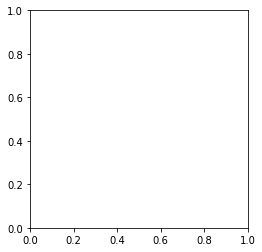

In [47]:
# Display image and label.
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
# print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")